#### (a)

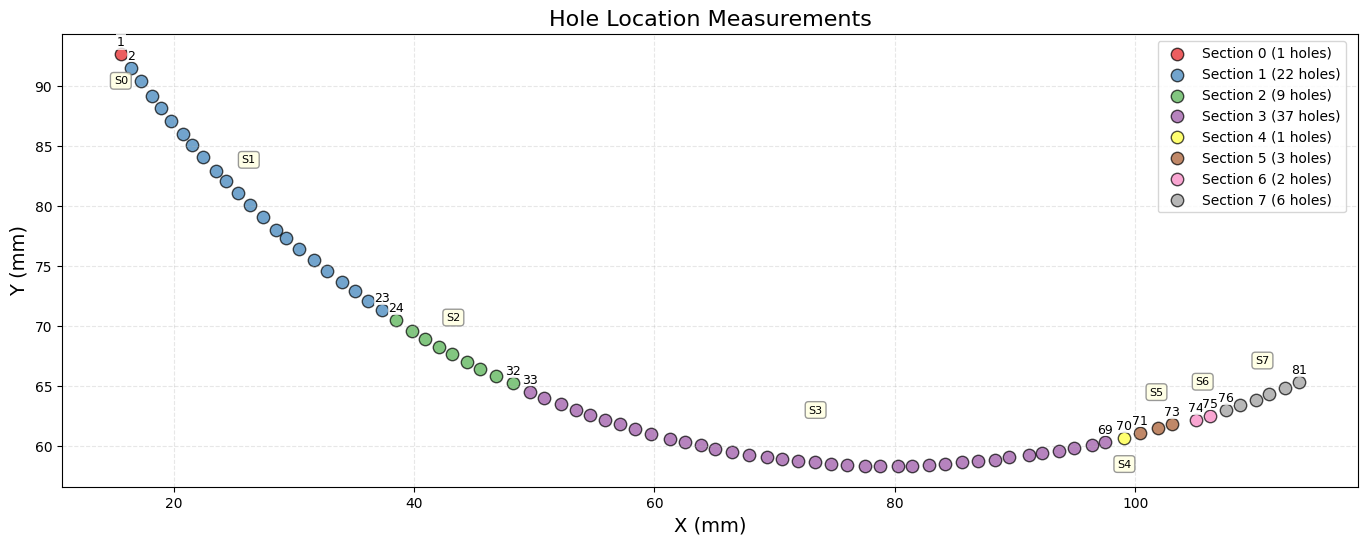

In [ ]:
from pathlib import Path
from antikythera import explore_data

data_path = Path("data/1-Fragment_C_Hole_Measurements.csv")
result_path = Path("results")
result_path.mkdir(exist_ok=True)

explore_data(data_path, result_path)

#### (d)

In [ ]:
from tabulate import tabulate
import numpy as np
import pandas as pd
from pathlib import Path
from antikythera import AntikytheraModel

data_path = Path("data/1-Fragment_C_Hole_Measurements.csv")

df = pd.read_csv(data_path)
data = np.array(df[['Mean(X)', 'Mean(Y)']])
sections = sorted(df['Section ID'].unique())
sorted_idxs = [list(df[df['Section ID'] == j]['Hole']) for j in sections]

model = AntikytheraModel(data, sorted_idxs)

# initialise
params_aniso = np.concatenate([[354], [100], [1, 1], np.zeros((8, 2)).flatten(), np.zeros(8)])
params_iso = np.concatenate([[354], [100], [1], np.zeros((8, 2)).flatten(), np.zeros(8)])

# check analytical gradients against numerical
aniso = model.check_grad(params_aniso, is_aniso=True)
iso = model.check_grad(params_iso, is_aniso=False)

# anisotropic
print("Anisotropic model gradient check:")
print(f"Max relative difference: {aniso['max_rel_diff']:.6e}")
aniso_table = []
for i in range(min(8, len(aniso['param_names']))):
    name = aniso['param_names'][i]
    analytical = aniso['analy_grad'][i]
    numerical = aniso['num_grad'][i]
    rel_diff = aniso['rel_diff'][i]
    aniso_table.append([name, f"{analytical:.6f}", f"{numerical:.6f}", f"{rel_diff:.6e}"])

aniso_table.append(["...", "...", "...", "..."])
print(tabulate(aniso_table, headers=["Param", "Analytical", "Numerical", "Rel Diff"], tablefmt="rounded_grid"))


# isotropic
print("\nIsotropic model gradient check:")
print(f"Max relative difference: {iso['max_rel_diff']:.6e}")
iso_table = []
for i in range(min(8, len(iso['param_names']))):
    name = iso['param_names'][i]
    analy = iso['analy_grad'][i]
    num = iso['num_grad'][i]
    rel_diff = iso['rel_diff'][i]
    iso_table.append([name, f"{analy:.6f}", f"{num:.6f}", f"{rel_diff:.6e}"])

iso_table.append(["...", "...", "...", "..."])
print(tabulate(iso_table, headers=["Param", "Analytical", "Numerical", "Rel Diff"], tablefmt="rounded_grid"))


Anisotropic model gradient check:
Max relative difference: 1.099508e-06
╭─────────┬───────────────┬───────────────┬──────────────╮
│ Param   │ Analytical    │ Numerical     │ Rel Diff     │
├─────────┼───────────────┼───────────────┼──────────────┤
│ N       │ 509.029084    │ 509.029109    │ 2.431333e-08 │
├─────────┼───────────────┼───────────────┼──────────────┤
│ r       │ -2224.360999  │ -2224.361058  │ 1.322940e-08 │
├─────────┼───────────────┼───────────────┼──────────────┤
│ sigma_r │ 103645.695286 │ 103645.539784 │ 7.501622e-07 │
├─────────┼───────────────┼───────────────┼──────────────┤
│ sigma_t │ 283130.281859 │ 283129.857038 │ 7.502215e-07 │
├─────────┼───────────────┼───────────────┼──────────────┤
│ x0_0    │ -84.400690    │ -84.400672    │ 1.080141e-07 │
├─────────┼───────────────┼───────────────┼──────────────┤
│ y0_0    │ 92.596530     │ 92.596543     │ 7.157034e-08 │
├─────────┼───────────────┼───────────────┼──────────────┤
│ alpha_0 │ -1563.220455  │ -1563.220460  │

#### (e)


Isotropic model maximum likelihood parameters:
N = 351.41
r = 76.51
sigma = 0.0880

Anisotropic model maximum likelihood parameters:
N = 355.25
r = 77.34
sigma_r = 0.0255
sigma_t = 0.1211


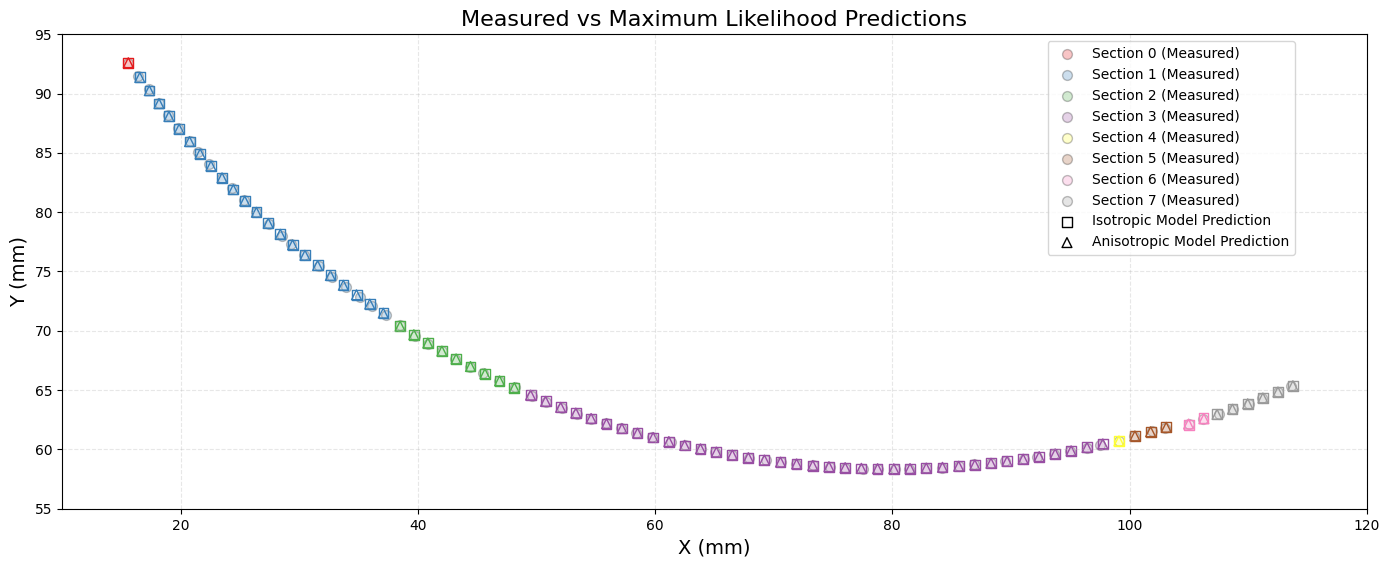

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from antikythera import AntikytheraModel, ml_estimate, plot_mle

data_path = Path("data/1-Fragment_C_Hole_Measurements.csv")
result_path = Path("results")
result_path.mkdir(exist_ok=True)

df = pd.read_csv(data_path)
data = np.array(df[['Mean(X)', 'Mean(Y)']])
sections = sorted(df['Section ID'].unique())
sorted_idxs = [list(df[df['Section ID'] == j]['Hole']) for j in sections]

model = AntikytheraModel(data, sorted_idxs)

init_iso = np.concatenate([[350], [100], [1], np.zeros((8, 2)).flatten(), np.zeros(8)])
init_aniso = np.concatenate([[350], [100], [1, 1], np.zeros((8, 2)).flatten(), np.zeros(8)])

mle_iso = ml_estimate(model, is_aniso=False, init=init_iso)

mle_aniso = ml_estimate(model, is_aniso=True, init=init_aniso)

# print the parameters
iso_dict = model.unpack_params(mle_iso)
aniso_dict = model.unpack_params(mle_aniso)

print("\nIsotropic model maximum likelihood parameters:")
print(f"N = {iso_dict['N']:.2f}")
print(f"r = {iso_dict['r']:.2f}")
print(f"sigma = {iso_dict['sigma'][0]:.4f}")

print("\nAnisotropic model maximum likelihood parameters:")
print(f"N = {aniso_dict['N']:.2f}")
print(f"r = {aniso_dict['r']:.2f}")
print(f"sigma_r = {aniso_dict['sigma'][0]:.4f}")
print(f"sigma_t = {aniso_dict['sigma'][1]:.4f}")

plot_mle(data, sorted_idxs, mle_iso, mle_aniso)

np.save(result_path /"mle_iso.npy", mle_iso)
np.save(result_path /"mle_aniso.npy", mle_aniso)


#### (f)

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import pickle
from antikythera import AntikytheraHMC

data_path = Path("data/1-Fragment_C_Hole_Measurements.csv")
result_path = Path("results")
result_path.mkdir(exist_ok=True)

df = pd.read_csv(data_path).drop([0, 69])   #  drop out sections 0, 4 which contain only one hole each
data = np.array(df[['Mean(X)', 'Mean(Y)']])
sections = sorted(df['Section ID'].unique())
sorted_idxs = [list(df[df['Section ID'] == j]['Hole']) for j in sections]

all_df = pd.read_csv(data_path)
all_data = np.array(all_df[['Mean(X)', 'Mean(Y)']])

sampler = AntikytheraHMC(all_data, sorted_idxs)

print('Sampling from posterior of isotropic model...')
iso_trace = sampler.sample(
    n_samples=2000,  
    n_tune=2000,     
    cores=4,        
    target_accept=0.95,  
    is_aniso=False,  
    N_prior=(335, 375),
    r_prior=(60, 90),   
    sigma_prior=(0.02, 0.2),  
    x0j_prior = (70, 90),
    y0j_prior = (125, 145),
    alpha_prior=(-3.0, -2.0)  
)

with open(result_path/"iso_trace.pkl", "wb") as f:
    pickle.dump(iso_trace, f)

print('Sampling from posterior of anisotropic model...')
aniso_trace = sampler.sample(
    n_samples=2000, 
    n_tune=2000,     
    cores=4,       
    target_accept=0.95, 
    is_aniso=True,  
    N_prior=(335, 375),
    r_prior=(60, 90),   
    sigma_prior=(0.02, 0.2),  
    x0j_prior = (70, 90),
    y0j_prior = (125, 145),  
    alpha_prior=(-3.0, -2.0) 
)

with open(result_path/"aniso_trace.pkl", "wb") as f:
    pickle.dump(aniso_trace, f)

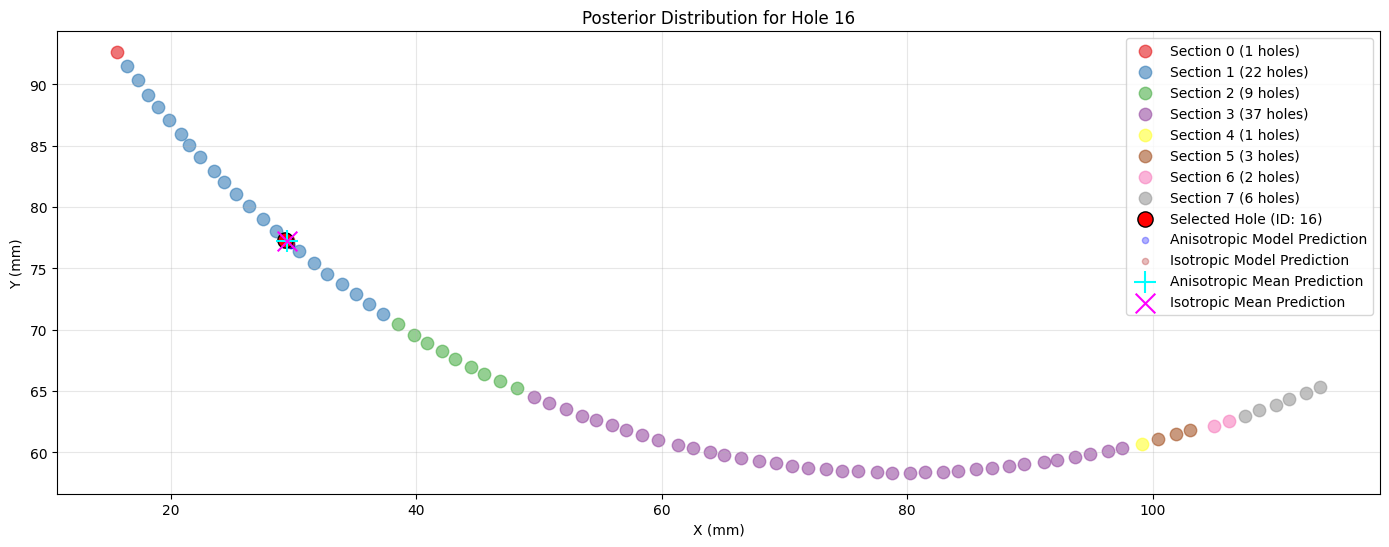

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
import arviz as az
from antikythera import position_samples

data_path = Path("data/1-Fragment_C_Hole_Measurements.csv")
result_path = Path("results")
result_path.mkdir(exist_ok=True)

with open(result_path/"iso_trace.pkl", "rb") as f:
    iso_trace = pickle.load(f)

with open(result_path/"aniso_trace.pkl", "rb") as f:
    aniso_trace = pickle.load(f)

nsamples=2000
section_idx = 0   # here it's actually S1 cuz S0 was dropped out
hole_idx = 16     # d_{16} in S1

# generate predictive samples
iso_samples = position_samples(iso_trace, False, hole_idx, section_idx, nsamples)
aniso_samples = position_samples(aniso_trace, True, hole_idx, section_idx, nsamples)

plt.figure(figsize=(14, 10))

df = pd.read_csv(data_path)
sections = sorted(df['Section ID'].unique())

colors = plt.cm.Set1(np.linspace(0, 1, len(sections)))

for i, section in enumerate(sections):
    section_data = df[df['Section ID'] == section]
    plt.scatter(
        section_data['Mean(X)'], 
        section_data['Mean(Y)'],
        s=80,  
        color=colors[i],
        alpha=0.6,
        label=f'Section {section} ({len(section_data)} holes)'
    )

hole_data = df[df['Hole'] == hole_idx]
plt.scatter(
    hole_data['Mean(X)'], 
    hole_data['Mean(Y)'],
    s=120,  
    color="red",
    label=f"Selected Hole (ID: {hole_idx})",
    edgecolor="black",
    zorder=10)

plt.scatter(aniso_samples[:, 0], aniso_samples[:, 1], 
            color="blue", alpha=0.3, label="Anisotropic Model Prediction", s=20)
plt.scatter(iso_samples[:, 0], iso_samples[:, 1], 
            color="firebrick", alpha=0.3, label="Isotropic Model Prediction", s=20)

sum_aniso = az.summary(aniso_trace)
sum_iso = az.summary(iso_trace)

mean_aniso = sum_aniso.loc[:, "mean"]
mean_iso = sum_iso.loc[:, "mean"]

# mean predictions of each parameters
N_aniso = mean_aniso["N"]
r_aniso = mean_aniso["r"]
x0_aniso = mean_aniso[f"x0_{section_idx}"]
y0_aniso = mean_aniso[f"y0_{section_idx}"]
alpha_aniso = mean_aniso[f"alpha_{section_idx}"]

N_iso = mean_iso["N"]
r_iso = mean_iso["r"]
x0_iso = mean_iso[f"x0_{section_idx}"]
y0_iso = mean_iso[f"y0_{section_idx}"]
alpha_iso = mean_iso[f"alpha_{section_idx}"]

# angular position for the selected hole
phi_aniso = 2 * np.pi * (hole_idx - 1) / N_aniso + alpha_aniso
phi_iso = 2 * np.pi * (hole_idx - 1) / N_iso + alpha_iso

# predicted positions using posterior means
x_pred_aniso = x0_aniso + r_aniso * np.cos(phi_aniso)
y_pred_aniso = y0_aniso + r_aniso * np.sin(phi_aniso)

x_pred_iso = x0_iso + r_iso * np.cos(phi_iso)
y_pred_iso = y0_iso + r_iso * np.sin(phi_iso)

# the mean predicted positions
plt.scatter(x_pred_aniso, y_pred_aniso, color="cyan", s=250, marker="+",
            label="Anisotropic Mean Prediction", zorder=10)
plt.scatter(x_pred_iso, y_pred_iso, color="fuchsia", s=200, marker="x",
            label="Isotropic Mean Prediction", zorder=10)

plt.grid(True, alpha=0.3)

#plt.xlim(27.5, 31.5)
#plt.ylim(76, 78.5)
plt.gca().set_aspect('equal', adjustable='box') 

plt.legend()
plt.xlabel("X (mm)")
plt.ylabel("Y (mm)")
plt.title(f"Posterior Distribution for Hole {hole_idx}")

plt.savefig(result_path/"posterior_distribution_zoomin.png", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
pd.set_option('display.width', 150)
pd.set_option('display.max_columns', None) 

print("\nIsotropic Model Posterior Summary:")
print(sum_iso.loc["N":"sigma", :])

print("\nAnisotropic Model Posterior Summary:")
print(sum_aniso.loc["N":"sigma_t", :])


Isotropic Model Posterior Summary:
          mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
N      355.374  4.341  347.697  363.841      0.135    0.071    1045.0    1930.0   1.01
r       77.370  0.935   75.714   79.178      0.029    0.015    1043.0    1850.0   1.01
sigma    0.094  0.006    0.084    0.105      0.000    0.000    6928.0    5259.0   1.00

Anisotropic Model Posterior Summary:
            mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
N        355.269  1.387  352.700  357.861      0.033    0.019    1771.0    3011.0    1.0
r         77.343  0.282   76.816   77.859      0.007    0.004    1714.0    2696.0    1.0
sigma_r    0.028  0.003    0.024    0.033      0.000    0.000    6408.0    3600.0    1.0
sigma_t    0.129  0.011    0.110    0.150      0.000    0.000    6338.0    4348.0    1.0


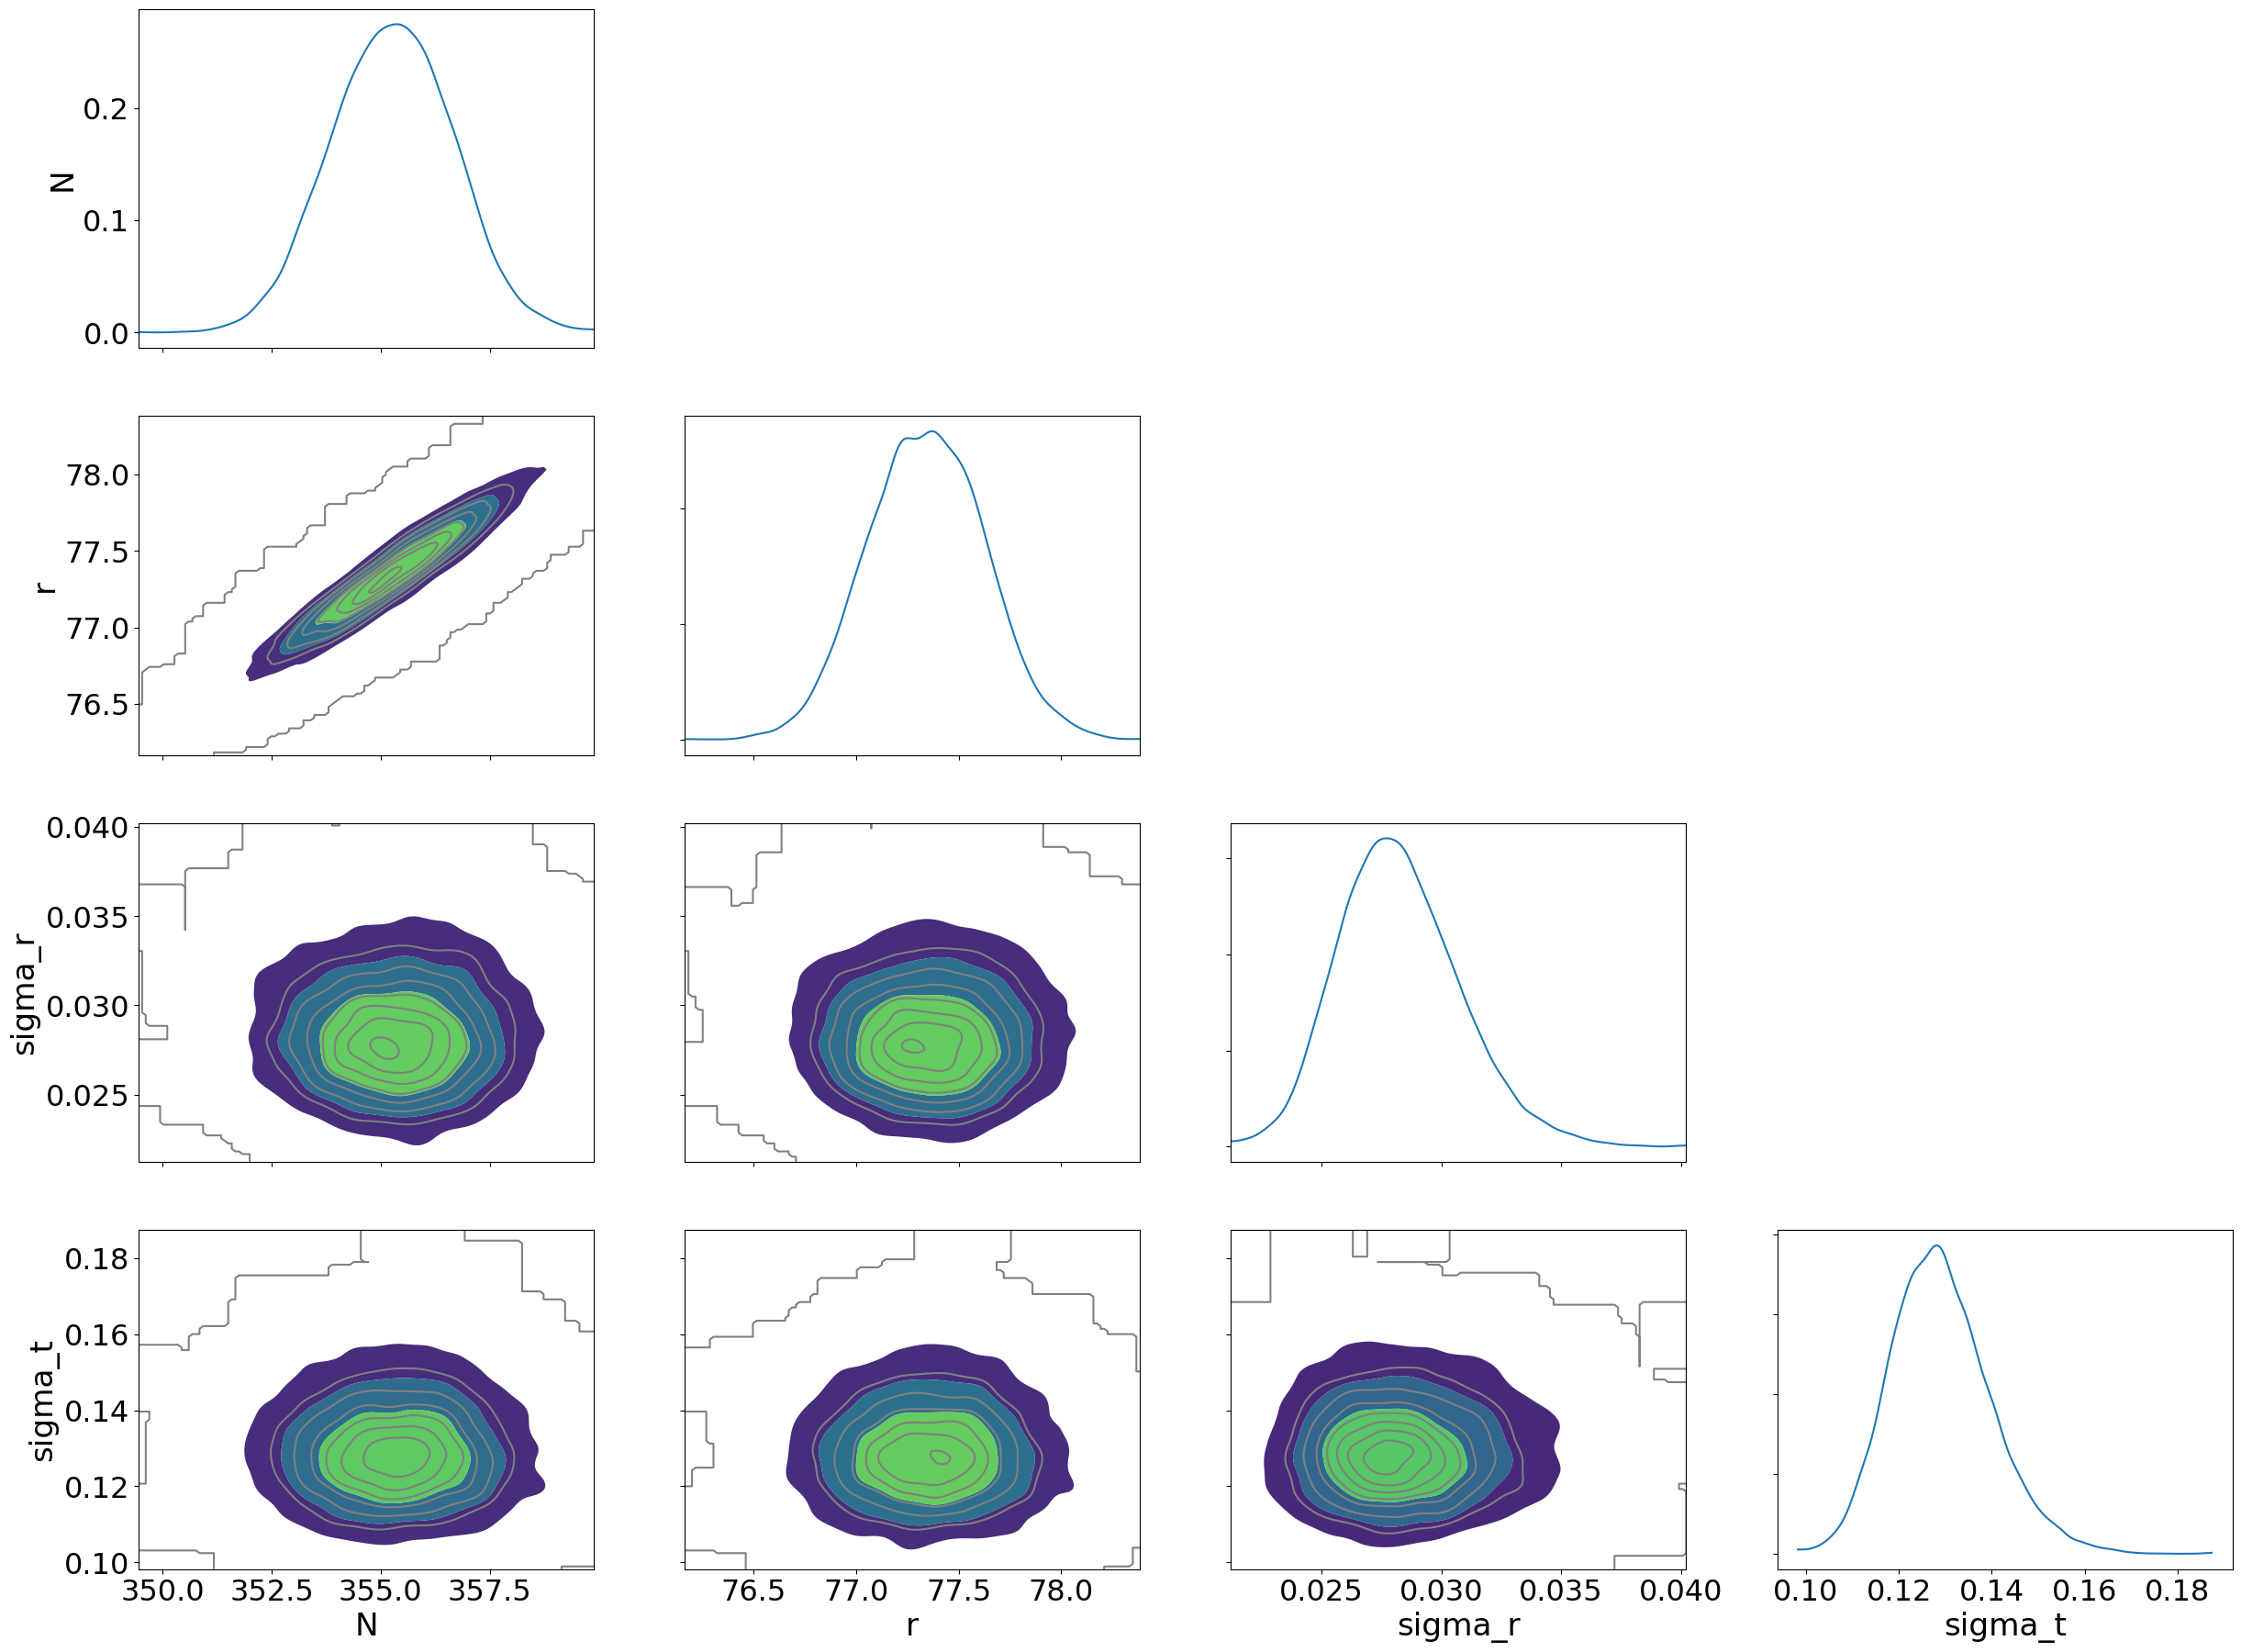

In [ ]:
import arviz as az
import matplotlib.pyplot as plt

az.plot_pair(
    aniso_trace,
    var_names=["N", "r", "sigma_r", "sigma_t"], 
    kind="kde",     
    marginals=True,  
    textsize=23
)

plt.savefig('results/corner_plot.png', dpi=600, bbox_inches='tight')

#### (g)

In [ ]:
from antikythera import ModelComparison, AntikytheraHMC
import pandas as pd
import numpy as np
from pathlib import Path
import pickle

data_path = Path("data/1-Fragment_C_Hole_Measurements.csv")
result_path = Path("results")
result_path.mkdir(exist_ok=True)

df = pd.read_csv(data_path).drop([0, 69])   #  drop out sections 0, 4 which contain only one hole each
data = np.array(df[['Mean(X)', 'Mean(Y)']])
sections = sorted(df['Section ID'].unique())
sorted_idxs = [list(df[df['Section ID'] == j]['Hole']) for j in sections]

all_df = pd.read_csv(data_path)
all_data = np.array(all_df[['Mean(X)', 'Mean(Y)']])

sampler = AntikytheraHMC(all_data, sorted_idxs)

comp = ModelComparison(sampler)

# run thermodynamic integration for both models
comp.run_therm_integ(
    name="Isotropic",
    is_aniso=False,
    n_samples=500,
    n_tune=500,
    cores=2
)

comp.run_therm_integ(
    name="Anisotropic",
    is_aniso=True,
    n_samples=500,
    n_tune=500,
    cores=2
)

with open(result_path/"model_comparison.pkl", "wb") as f:
    pickle.dump(comp, f)


In [4]:
import numpy as np
from pathlib import Path
import pickle

result_path = Path("results")

with open(result_path/"model_comparison.pkl", "rb") as f:
    comp = pickle.load(f)

# compare models
better, bf = comp.compare_models()
logZ1 = comp.log_evidence["Isotropic"]
logZ2 = comp.log_evidence["Anisotropic"]

Z1 = np.exp(logZ1)
Z2 = np.exp(logZ2)

print(f"The better model is {better}, the bayes factor is {bf}.\n")
print(f"The approx evidence for isotropic model is: Z1={Z1:.2e}")
print(f"The approx evidence for anisotropic model is: Z2={Z2:.2e}")


The better model is Anisotropic, the bayes factor is 0.051544204031018635.

The approx evidence for isotropic model is: Z1=5.77e-29
The approx evidence for anisotropic model is: Z2=1.12e-27


In [15]:
from tabulate import tabulate
headers = [f"β{i}" for i in range(len(comp.temperatures))]
tab_temperatures = [[f"{i:.1e}" for i in comp.temperatures]]
print("The temperaters used are:")
print(tabulate(tab_temperatures, headers=headers, tablefmt="rounded_grid"))

The temperaters used are:
╭──────┬───────┬─────────┬─────────┬─────────┬────────┬────────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────╮
│   β0 │    β1 │      β2 │      β3 │      β4 │     β5 │     β6 │     β7 │    β8 │    β9 │   β10 │   β11 │   β12 │   β13 │   β14 │   β15 │   β16 │   β17 │   β18 │   β19 │
├──────┼───────┼─────────┼─────────┼─────────┼────────┼────────┼────────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┼───────┤
│    0 │ 4e-07 │ 1.3e-05 │ 9.8e-05 │ 0.00041 │ 0.0013 │ 0.0031 │ 0.0068 │ 0.013 │ 0.024 │  0.04 │ 0.065 │   0.1 │  0.15 │  0.22 │  0.31 │  0.42 │  0.57 │  0.76 │     1 │
╰──────┴───────┴─────────┴─────────┴─────────┴────────┴────────┴────────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴───────┴───────╯
